# Forecasting Alcohol Sales with a Reccurent Neural Network
The data is from the Federal Reserve Economic Database (FRED) concerning Sales of Beer, Wine, and Distilled Alcoholic Beverages in millions of dollars from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/S4248SM144NCEN

## Perform standard imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

warnings.filterwarnings('ignore')
%matplotlib inline

A:\anaconda3\envs\pytorchenv\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
register_matplotlib_converters()

## Load the dataset

In [3]:
df = pd.read_csv('./DATA/Alcohol_Sales.csv',index_col=0,parse_dates=True)
len(df)

325

In [4]:
# Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

325

In [5]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [6]:
df.tail()

,S4248SM144NCEN
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


## Plotting the time series data

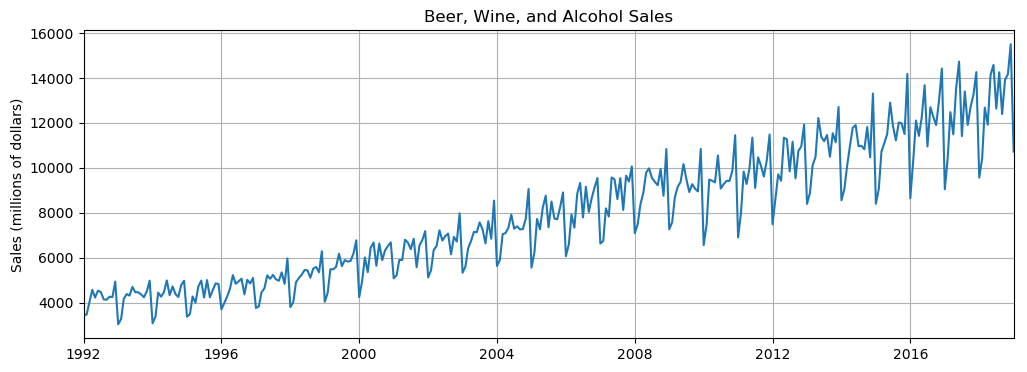

In [7]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Preparing the data

In [8]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [9]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

## Normalize the data
The formula for normalizing data around zero is:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the population mean, and $\sigma$ is the population standard deviation.<br>

And we perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> so that our values fall between -1 and 1, as this makes hyperparameters converge faster.<br>The formula for this would be:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$<br>

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [11]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [12]:
train_norm.min()

-1.0

In [13]:
train_norm.max()

1.0

In [14]:
train_norm.mean()

-0.2041940178388313

In [15]:
type(train_norm)

numpy.ndarray

## Prepare data for LSTM
Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [16]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

301

In [17]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

## Define the model
This time we'll use an LSTM layer of size (1,100).

In [18]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

## Instantiate the model, define loss and optimization functions

In [19]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [20]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


## Train the model

In [21]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.25314346
Epoch:  2 Loss: 0.37523872
Epoch:  3 Loss: 0.39012119
Epoch:  4 Loss: 0.34949672
Epoch:  5 Loss: 0.33077902
Epoch:  6 Loss: 0.33230725
Epoch:  7 Loss: 0.32667691
Epoch:  8 Loss: 0.32077032
Epoch:  9 Loss: 0.30651760
Epoch: 10 Loss: 0.29517007
Epoch: 11 Loss: 0.26913962
Epoch: 12 Loss: 0.25979343
Epoch: 13 Loss: 0.24600154
Epoch: 14 Loss: 0.22227859
Epoch: 15 Loss: 0.18593550
Epoch: 16 Loss: 0.18445915
Epoch: 17 Loss: 0.17433032
Epoch: 18 Loss: 0.25821683
Epoch: 19 Loss: 0.22418253
Epoch: 20 Loss: 0.23127888
Epoch: 21 Loss: 0.19784078
Epoch: 22 Loss: 0.19101219
Epoch: 23 Loss: 0.21623559
Epoch: 24 Loss: 0.16621800
Epoch: 25 Loss: 0.14614266
Epoch: 26 Loss: 0.12386617
Epoch: 27 Loss: 0.09243379
Epoch: 28 Loss: 0.00801597
Epoch: 29 Loss: 0.00206853
Epoch: 30 Loss: 0.03982832
Epoch: 31 Loss: 0.00813899
Epoch: 32 Loss: 0.04257211
Epoch: 33 Loss: 0.03458070
Epoch: 34 Loss: 0.02677556
Epoch: 35 Loss: 0.03034122
Epoch: 36 Loss: 0.01139324
Epoch: 37 Loss: 0.00260192
E

## Run predictions and compare to known test set

In [22]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [23]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.290490061044693,
 0.654594361782074,
 0.4744340777397156,
 0.8252239227294922,
 1.0622273683547974,
 0.39335811138153076,
 0.7735922336578369,
 0.5423380732536316,
 0.6198782920837402,
 0.8178079128265381,
 0.9394367933273315,
 0.1507076919078827]

## Invert the normalization
We want to compare our test predictions to the original data, so we need to undo the previous normalization step.

In [24]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[10579.72161208],
       [12709.54971924],
       [11655.70213774],
       [13707.64733601],
       [15093.99899119],
       [11181.44827253],
       [13405.62777078],
       [12052.9065595 ],
       [12506.47806954],
       [13664.26738608],
       [14375.73552257],
       [ 9762.06464382]])

In [25]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

It looks like our predictions weren't that far off!
## Plot the results
Our original data contains a datetime index, but our predicted values do not. We can create a range of dates using NumPy that are spaced one month apart using <tt>dtype='datetime64[M]'</tt>, and then store them with day values to match our dataset with <tt>.astype('datetime64[D]')</tt>.

In [26]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

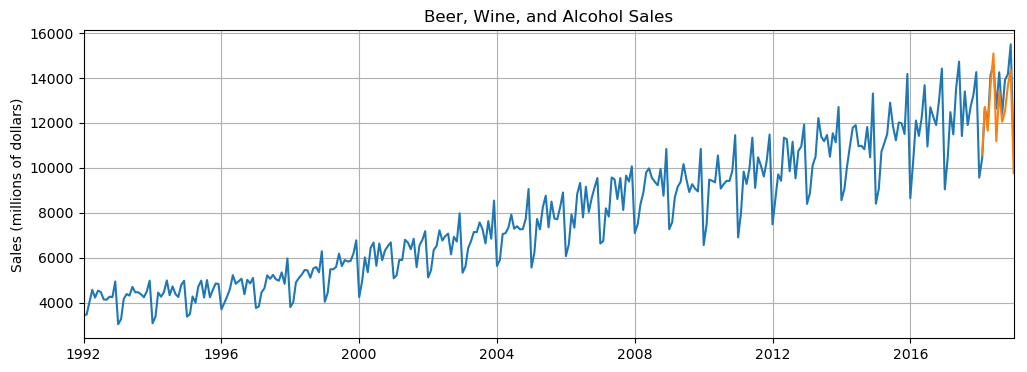

In [27]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

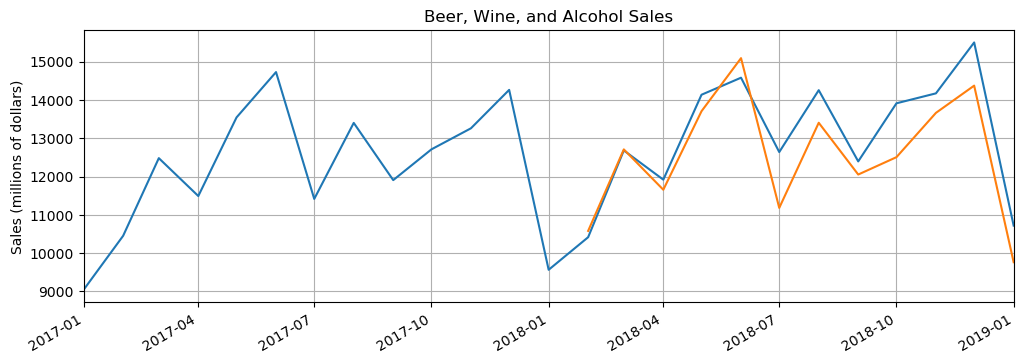

In [28]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

# Forecast into an unknown future
Continuing training the model using the entire dataset, and predict 12 steps into the future.

In [29]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.02299759
Epoch:  2 Loss: 0.03850218
Epoch:  3 Loss: 0.02216407
Epoch:  4 Loss: 0.01759366
Epoch:  5 Loss: 0.01667951
Epoch:  6 Loss: 0.01552761
Epoch:  7 Loss: 0.01439477
Epoch:  8 Loss: 0.01384568
Epoch:  9 Loss: 0.01319483
Epoch: 10 Loss: 0.01313994
Epoch: 11 Loss: 0.01226208
Epoch: 12 Loss: 0.01276728
Epoch: 13 Loss: 0.00909276
Epoch: 14 Loss: 0.00870438
Epoch: 15 Loss: 0.01136363
Epoch: 16 Loss: 0.00857798
Epoch: 17 Loss: 0.00645762
Epoch: 18 Loss: 0.01227561
Epoch: 19 Loss: 0.00768364
Epoch: 20 Loss: 0.00697160
Epoch: 21 Loss: 0.00790762
Epoch: 22 Loss: 0.00698379
Epoch: 23 Loss: 0.00732160
Epoch: 24 Loss: 0.00470513
Epoch: 25 Loss: 0.00587853
Epoch: 26 Loss: 0.00914662
Epoch: 27 Loss: 0.00703951
Epoch: 28 Loss: 0.00656393
Epoch: 29 Loss: 0.00719578
Epoch: 30 Loss: 0.00581549
Epoch: 31 Loss: 0.00702170
Epoch: 32 Loss: 0.00628963
Epoch: 33 Loss: 0.00853426
Epoch: 34 Loss: 0.00793936
Epoch: 35 Loss: 0.00888516
Epoch: 36 Loss: 0.00966777
Epoch: 37 Loss: 0.00492449
E

## Predict future values, plot the result

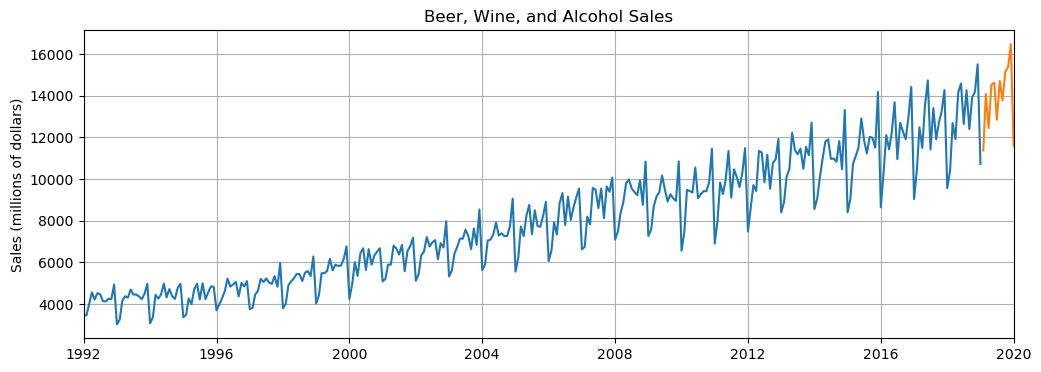

In [30]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

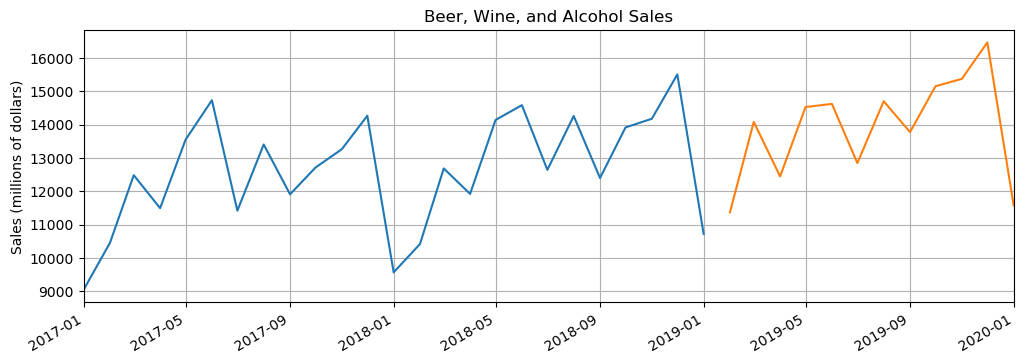

In [31]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()

In [32]:
# Load dependencies


# Instantiate a scaler
"""
This has to be done outside the function definition so that
we can inverse_transform the prediction set later on.
"""
scaler = MinMaxScaler(feature_range=(-1, 1))

# Extract values from the source .csv file
df = pd.read_csv('./DATA/Alcohol_Sales.csv',index_col=0,parse_dates=True)
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create the training set of values
train_set = y[:-test_size]

In [33]:
# DEFINE A FUNCTION:
def create_train_data(seq,ws=12):
    """Takes in a training sequence and window size (ws) of
       default size 12, returns a tensor of (seq/label) tuples"""
    seq_norm = scaler.fit_transform(seq.reshape(-1, 1))    
    seq_norm = torch.FloatTensor(seq_norm).view(-1)

    out = []
    L = len(seq_norm)
    for i in range(L-ws):
        window = seq_norm[i:i+ws]
        label = seq_norm[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [34]:
# Apply the function to train_set
train_data = create_train_data(train_set,12)
len(train_data)

301

In [35]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))